<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/221009_Temporal_pathway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 5.1 MB/s 


In [2]:
import numpy as np
def MAF(x,window):
    new_signals = np.zeros(x.shape)
    sample_num, T = x.shape
    for i in range(sample_num):
      noise = np.convolve(x[i], np.ones(window),'same')/window
      new_signals[i] = x[i] - noise
   
    return new_signals


def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,1,T) - b*np.ones(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n == 0:
      new_signals = x + noise
    else:
      new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - d*np.ones(T)
    noise = c*np.sin(noise)*np.ones((C,1))
    new_signals = x + noise
    return new_signals

In [3]:
def augmented_data(x,window,a,b,c,d):
      batch,channel,time = x.shape
      x = np.reshape(x,(batch*channel,time))
      # print(x.shape)
      x = x.numpy()
      samples, sequence_length = x.shape
      X = []
      Y = []
      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      X.append(x)
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]

      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)

      X = X.reshape(4*samples,sequence_length)
      # print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y

In [4]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
          
    def __len__(self):
        return self.data_adress[-1]


In [5]:
class MASS_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # self.freq = 1.28 # 256Hz / 1.28 = 200Hz
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
      
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
    def __len__(self):
        return self.data_adress[-1]

In [6]:
from sklearn.model_selection import train_test_split

class concat_dataset():
    def __init__(self, data_dic,seq_len):
        self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
        self.seq_len = seq_len
    
    def tr_val_te_split(self,data_list):
        train, test = train_test_split(data_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
        train, val = train_test_split(train, test_size= 0.25)#, shuffle=True, random_state=34)
        del data_list
        print('split done')
        return train, val, test    
    
    def call(self):
        # train_dataset = [] # extend로 빈 어레의 받으면 메모리가 터지는 문제 발생했음.
        # val_dataset = []
        # test_dataset = []
    
        for name, data_list in self.data_dic.items():
            print(name)
            tr, val, te = self.tr_val_te_split(data_list)
            
            if name =='Sleep_edf':
                sleepedf_train_data = Sleepedf_dataset(tr,self.seq_len,SSL = True)
                print('sleep train done')
                sleepedf_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('sleep val done')
                sleepedf_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('sleep test done')
            
            elif name == 'MASS':
                MASS_train_data = Sleepedf_dataset(tr,self.seq_len, SSL = True)
                print('MASS train done')
                MASS_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('MASS val done')
                MASS_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('MASS test done')
        
            # train_dataset.extend(train_data)
            # val_dataset.extend(val_data)
            # test_dataset.extend(test_data)
            # print(train_data)

        # del train_data,val_data, test_data
    
        train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
        val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
        test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
        return train_dataset, val_dataset, test_dataset

In [7]:
from torch.utils.data import random_split

class concat_dataset():
    def __init__(self, data_dic,seq_len):
        self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
        self.seq_len = seq_len
    
    def call(self):
        # train_dataset = [] # extend로 빈 어레의 받으면 메모리가 터지는 문제 발생했음.
        # val_dataset = []
        # test_dataset = []
    
        for name, data_list in self.data_dic.items():

            if name =='Sleep_edf':
                sleepedf_data = Sleepedf_dataset(data_list,self.seq_len,SSL = True)
            
            elif name == 'MASS':
                MASS_data = Sleepedf_dataset(data_list,self.seq_len, SSL = True)
               
        sleepedf_train_data, sleepedf_val_data, sleepedf_test_data = random_split(sleepedf_data, [int(0.8*len(sleepedf_data)), int(0.1*len(sleepedf_data)), int(0.1*len(sleepedf_data))], generator=torch.Generator().manual_seed(42))
        MASS_train_data, MASS_val_data, MASS_test_data = random_split(MASS_data, [int(0.8*len(MASS_data)), int(0.1*len(MASS_data)), int(0.1*len(MASS_data))], generator=torch.Generator().manual_seed(42))


        train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
        val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
        test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
        return train_dataset, val_dataset, test_dataset

In [8]:
import glob
temp = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEG/SS1_0/**')

In [9]:
train_dataset = MASS_dataset(temp,2000, SSL = True) 

In [10]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = 512 , shuffle=True)


In [11]:
import time
start_T = time.time()
for batch_idx, batch in enumerate(trainLoader):
  print('batch_idx:',batch_idx,' ',batch.shape)
  end_T = time.time()
  print('time:', end_T - start_T)
  if batch_idx >= 2:
        break

batch_idx: 0   torch.Size([512, 18, 2000])
time: 3.1474103927612305
batch_idx: 1   torch.Size([512, 18, 2000])
time: 9.379547595977783
batch_idx: 2   torch.Size([512, 18, 2000])
time: 13.18162727355957


In [12]:
x,y = augmented_data(batch[:2,:2,:],100,0.6,0,0.6,1.5)

In [13]:
print(x.shape)
print(y.shape)

(16, 2000)
(16, 4)


[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


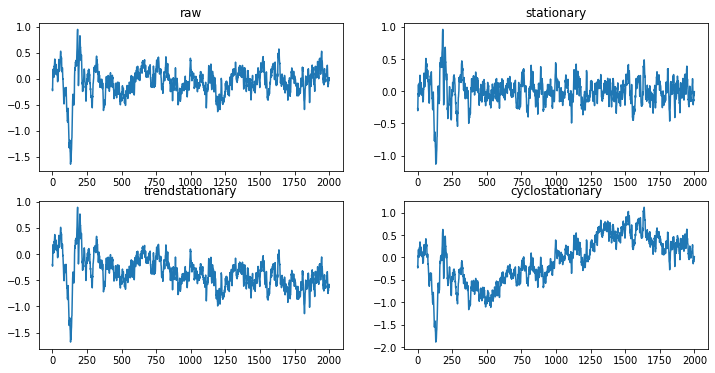

In [14]:
import matplotlib.pyplot as plt

sequence_length = 2000
t = np.linspace(0,sequence_length,sequence_length)
plt.figure(figsize =(12, 6))
label = ['S1_raw','S2_raw','S1_stationary','S2_stationary',
         'S1_trendstationary','S2_trendstationary','S1_cyclostationary','S2_cyclostationary']


label = ['raw','stationary','trendstationary','cyclostationary']


for i in range(4):
  k = x[i*4]
  print(y[i*4])
  plt.subplot(2, 2, i+1)
  plt.plot(t,k)
  plt.title(label[i])

In [15]:
SC_list = glob.glob('/content/drive/MyDrive/sleep_edfx/Preprocessed_EEG/SC/**')
print(len(SC_list))
sleepedf_list = []
for i in range(2):
  length = len(sleepedf_list)
  sleepedf_list.extend(glob.glob(SC_list[i]+'/**'))
  print(len(sleepedf_list) - length)
len(sleepedf_list)

153
2650
2830


5480

In [16]:
SS1_list = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEG/**')
print(len(SS1_list))
MASS_list = []
for i in range(7,14):
    length = len(MASS_list)
    MASS_list.extend(glob.glob(SS1_list[i]+'/**'))
    print(len(MASS_list) - length)
print(len(MASS_list))

53
1004
1071
937
1041
1079
991
877
7000


In [17]:
data_dic = {'MASS' : MASS_list[:1000], 'Sleep_edf': sleepedf_list[:1000]}

In [18]:
train_dataset, val_dataset, test_dataset = concat_dataset(data_dic, seq_len = 4000).call()

In [19]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = 4 , shuffle= False)


In [20]:
import time
start_T = time.time()
for batch_idx, batch in enumerate(trainLoader):
  print('batch_idx:',batch_idx,' ',batch.shape)
  end_T = time.time()
  print('time:', end_T - start_T)
  if batch_idx >= 10:
        break

batch_idx: 0   torch.Size([4, 2, 4000])
time: 0.011834859848022461
batch_idx: 1   torch.Size([4, 2, 4000])
time: 0.022246122360229492
batch_idx: 2   torch.Size([4, 2, 4000])
time: 0.03424954414367676
batch_idx: 3   torch.Size([4, 2, 4000])
time: 0.044516801834106445
batch_idx: 4   torch.Size([4, 2, 4000])
time: 0.054383039474487305
batch_idx: 5   torch.Size([4, 2, 4000])
time: 0.06424951553344727
batch_idx: 6   torch.Size([4, 2, 4000])
time: 0.07461810111999512
batch_idx: 7   torch.Size([4, 2, 4000])
time: 0.0844571590423584
batch_idx: 8   torch.Size([4, 2, 4000])
time: 0.09445691108703613
batch_idx: 9   torch.Size([4, 2, 4000])
time: 0.10418438911437988
batch_idx: 10   torch.Size([4, 2, 4000])
time: 0.11452388763427734


In [21]:
class Temporal_Trend_Identification_Task_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, device = None):
        super().__init__()
        self.device = device

    def forward(self, batch, encoder, train):
        acc = 0
        x, y = augmented_data(batch,window = 100, a= 0.7, b = 0, c = 0.7, d= 1.5)
        c,t = x.shape
        x = np.reshape(x,(c,1,t))
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(x).to(device))
        y = torch.Tensor(y).to(device)
        _, y =  torch.max(y, 1) 
        
      
        # print('y:',y.shape)
        # print('rept:',rept.shape)
        loss = CrossEL(pred, torch.Tensor(y).to(device))
        if train:
            loss.backward(retain_graph=True)

        _, predicted = torch.max(pred, 1) 
        # print(predicted.shape)
        # print(y.shape)
        acc = (predicted == y).sum().item()
        acc = acc/c #acc/(batch*channels*4(augmented))
        loss = loss
        del x
        del y
        return loss, acc


In [22]:
import torch
import torch.nn as nn



class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        # self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(256000 ,4) # 

      
    def embedding(self, x):
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [23]:
import os
import torch
# batch size
batch_size = 20
learning_rate = 0.0001
epochs = 10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

In [24]:
print(device)

cuda:0


In [25]:

# dataset loader

print("tainLoader")
trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
valLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

tainLoader


In [26]:

model = feature_extractor3().to(device)
#model.to(device)
criterion = Temporal_Trend_Identification_Task_Loss(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
import matplotlib.pyplot as plt
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        # print(batch.shape)
        optimizer.zero_grad()
        loss_batch, acc_batch = criterion.forward(batch, model, train = True)
        # print(batch_idx)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0
    for batch_idx, batch in enumerate(valLoader):
        loss_batch_val, acc_batch_val = criterion.forward(batch, model, train = False)
        loss_ep_val += loss_batch_val.item()
        acc_ep_val += acc_batch_val
    
    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  1.0571229331195355 train acc :  0.7128038194444446     val loss :  1.0138923674821854 val acc :  0.7649305555555556
epoch :  1   train loss :  0.9464171528816223 train acc :  0.8061284722222221     val loss :  0.911406896263361 val acc :  0.843125
epoch :  2   train loss :  0.8970246247947216 train acc :  0.8446440972222222     val loss :  0.9343983076512814 val acc :  0.8094618055555556
epoch :  3   train loss :  0.9013133279979229 train acc :  0.8382899305555555     val loss :  0.8845614820718766 val acc :  0.8569791666666667
epoch :  4   train loss :  0.8922919109463692 train acc :  0.8465798611111112     val loss :  0.8815739095211029 val acc :  0.858133680555555
epoch :  5   train loss :  0.8844794429838657 train acc :  0.8542708333333333     val loss :  0.8717191979289055 val acc :  0.8676736111111112
epoch :  6   train loss :  0.8726251229643822 train acc :  0.8655815972222225     val loss :  0.8900898322463036 val acc :  0.8484982638888889
epoch :  7 

result save and plot

In [28]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('Sleepedf+MASS_20s.xlsx', index = False)

(4, 10)


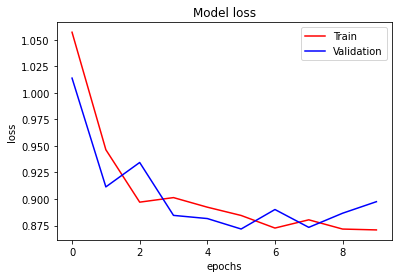

In [29]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Sleepedf+MASS_loss_20s',bbox_inches = 'tight')
plt.show()


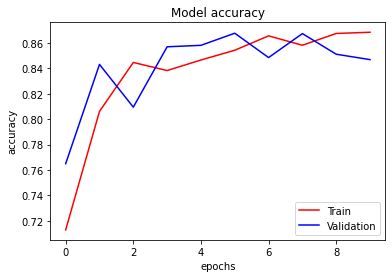

In [30]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Sleepedf+MASS_accuracy_20s',bbox_inches = 'tight')
plt.show()

In [31]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [32]:
def predict( batch, encoder):
  x, y = augmented_data(batch,window = 100 , a= 0.7, b = 0, c = 0.7, d= 1.5)
  c,t = x.shape
  # print('bj',x.shape)
  x = np.reshape(x,(c,1,t))
      
  rept = encoder.forward(torch.Tensor(x).to(device))
  
  rept = rept.cpu().detach().numpy()
  
  return rept, y

In [33]:
Y_hat = []
Y = []
for batch_idx, batch in enumerate(testLoader):
  y_hat,y = predict(batch, encoder = model)

  Y_hat.extend(y_hat)
  Y.extend(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
Y_hat = np.array(Y_hat)
print(Y_hat.shape)

Y = np.array(Y)
print(Y.shape)

(8000, 4)
(8000, 4)


In [35]:
y_hat

array([[9.9951530e-01, 0.0000000e+00, 4.8471621e-04, 2.2762625e-10],
       [3.9592904e-01, 1.3403817e-34, 6.0407096e-01, 4.6413099e-12],
       [6.6423577e-01, 1.4012985e-44, 3.3576420e-01, 8.5466221e-13],
       ...,
       [3.0957272e-05, 1.3196028e-41, 4.5569392e-29, 9.9996901e-01],
       [3.8461090e-05, 1.4808488e-39, 2.9111356e-28, 9.9996150e-01],
       [6.2140272e-05, 1.0367101e-36, 5.8364259e-27, 9.9993789e-01]],
      dtype=float32)

In [36]:
Y_tensor = torch.Tensor(Y)
_, Y_tensor =  torch.max(Y_tensor, 1) 
Y_hat_tensor = torch.Tensor(Y_hat)


_, predicted = torch.max(Y_hat_tensor, 1) 
# print(predicted.shape)
# print(y.shape)
print(predicted.shape)
correct = (predicted == Y_tensor).sum().item()
wrong = len(Y) - correct

torch.Size([8000])


In [37]:
print(Y_tensor)
print(predicted)

tensor([0, 0, 0,  ..., 3, 3, 3])
tensor([0, 0, 0,  ..., 3, 3, 3])


In [38]:
correct, wrong

(7446, 554)

In [39]:
print('accuracy:',correct/(correct + wrong))

accuracy: 0.93075


In [40]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_tensor, predicted)
print(conf_matrix)



[[1974   24    2    0]
 [  39 1961    0    0]
 [ 409   80 1511    0]
 [   0    0    0 2000]]


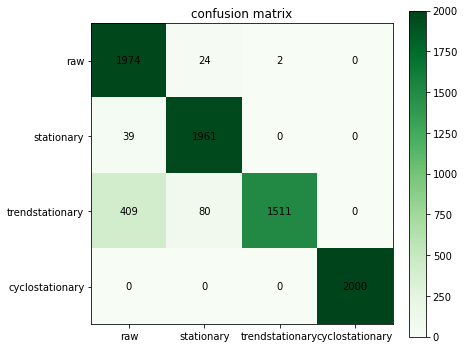

In [41]:
#one-hot encoding
      # original = [1,0,0,0]
      # s_maf = [0,1,0,0]
      # s_asln = [0,0,1,0]
      # s_apn = [0,0,0,1]

title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(4, 4)
plt.xticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))
plt.yticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment

plt.savefig('Sleepedf+MASS_confusionmatrix_20s',bbox_inches = 'tight')


In [42]:
torch.save(model,'Temporal_(150,7,7)_20s.pt')

In [43]:
torch.save(model.state_dict(),'Temporal_(150,77)_20s_stat_dict.pt')

In [52]:
import numpy as np
import torch
import torch.nn as nn
from mne.filter import filter_data, notch_filter
import matplotlib.pyplot as plt
# import hypertools as hyp
from sklearn.metrics import f1_score

def accuracy_check(pred, label):
    prediction = np.argmax(pred, axis=1)
    lb = np.argmax(label, axis=1)

    compare = np.equal(lb, prediction)
    accuracy = np.sum(compare.tolist()) / len(compare.tolist())

    f1acc = f1_score(lb, prediction, average='micro')

    return accuracy, f1acc

def dotprod_sample(sample):
    length = sample.shape[0]
    sam = nn.functional.normalize(sample.reshape([length,-1]), dim=1)
    result = torch.matmul(sam, sam.T)

    return result


TRAIN = 0
VALIDATION = 1
TEST = 2

class StoppedBandPredTaskLoss(torch.nn.modules.loss._Loss):
    def __init__(self, bands, labels, device):
        super().__init__()
        self.device = device
        self.BAND = bands
        self.LABEL = labels

    def forward(self, batch, encoder, sfreq, train):
        batch_aug = []
        batch_label = []
        b,c,t = batch.shape
        batch = np.reshape(batch,(b*c,t))        #Band has freqeuncy range, filter_data plays the role of Band Stop filter
        
        #each Labels are composed of one-hot vectors and are copied ( Bands size * Batch size )
        for idx,band in enumerate(self.BAND):
            lfreq, rfreq = band
            data = filter_data(batch.numpy().astype(np.float64), sfreq=sfreq, l_freq=rfreq, h_freq=lfreq, verbose=False)
            batch_aug.append(data)
            batch_label.append(data.shape[0] * [self.LABEL[idx]])

        #[batch, augmentation, channel, time length] -> [batch*augmentation, channel, time length]
        b,a,l = np.array(batch_aug).shape
        batch_aug = np.array(batch_aug).reshape([b*a,l])
        batch_label = np.array(batch_label).reshape([b*a,len(self.LABEL)])
        batch_aug = np.reshape(batch_aug,(b*a,1,l))
        batch_label = torch.Tensor(batch_label).to(device)
        
  
        #Self-supervised Learning Loss is CrossEntropy
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(batch_aug).to(device))
        loss = CrossEL(pred, batch_label)
      
        _, y =  torch.max(batch_label, 1) 
        _, predicted = torch.max(pred, 1) 

        if TRAIN:
            loss.backward(retain_graph=True)

        # print(predicted.shape)
        # print(y.shape)
        acc = (predicted == y).sum().item()
        acc = acc/(b*a) #acc/(batch*channels*4(augmented))
        loss = loss
        # print(type(loss))
        del y
        return loss, acc

In [48]:
def weight_init_xavier_uniform(submodule):
    # if isinstance(submodule, snn.SeparableConv1d):
    #     torch.nn.init.xavier_uniform_(submodule.weight)

    if isinstance(submodule, nn.Linear):
        torch.nn.init.xavier_uniform_(submodule.weight)

class Encoder(nn.Module):
    def __init__(self, fs, encode_info):
        super(Encoder, self).__init__()
        #spectral layer means spectral convolution
        #self.bac_layer is consist of several SeparableConv2d, which plays the role of temporal separable convolution
        #convolution layer are initiated by xavier_uniform initization
        #Input are Normalized by self.bn(=torch.nn.BatchNorm2d)
        #[batch, electrode, length] -> [batch, electrode, Feature]
        self.fs = fs
        self.elu = nn.ELU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(1)

        self.spectral_layer = nn.Conv1d(1, 10, int(self.fs/2), padding="same")

        self.bac_layer = nn.Sequential()
        for i, arg in enumerate(encode_info):
            input_dim, output_dim, kernel_size = arg
            self.bac_layer.add_module("temporal_conv_"+str(i),
                                  nn.Conv1d(input_dim, output_dim, kernel_size, padding = 'same'))
            self.bac_layer.add_module("ELU",nn.ELU())

        torch.nn.init.xavier_uniform_(self.spectral_layer.weight)
        #self.bac_layer.apply(weight_init_xavier_uniform)

    def forward(self, x):
        x = self.elu(self.spectral_layer(x))
        x = self.bac_layer(x)
      
        return x

#Linear layer for SSL classification
class Head_NN(nn.Module):
    def __init__(self, length):
        super(Head_NN, self).__init__()
        self.length = length
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.length*64, 5)
        )
        self.softmax = torch.nn.Softmax(dim=1)
        self.layer.apply(weight_init_xavier_uniform)
        self.bn = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer(x)
        x = self.softmax(x)
        return x

class StoppedBandPathway(nn.Module):
    def __init__(self, fs, Unsupervise, encode_info, bands):
        super(StoppedBandPathway, self).__init__()
        self.encoder = Encoder(fs, encode_info)
        self.pretrain = Head_NN(4000)
        self.Unsupervise = Unsupervise


    def forward(self, x):
        x = self.encoder(x)
        x = self.pretrain(x)
        return x

    def getRep(self, x):
        x = self.encoder(x)
        return x


In [49]:

import os
import torch
# batch size
batch_size = 20
learning_rate = 0.0001
epochs = 10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

In [53]:
BANDS = [(0.5,4), (4,8), (8,15), (15,30), (30,49.9)]
LABEL = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]

encode_info = [(10, 16, 30),(16, 32, 15),(32, 64, 30)]
sfreq = 200


model = StoppedBandPathway(sfreq,True,encode_info,BANDS).to(device)
#model = MSNN.feature_extractor3(sfreq).to(device)

# Custom Tripletloss
criterion = StoppedBandPredTaskLoss(BANDS, LABEL, device=device)


# use SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [54]:
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []

for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    #concatdata.getTrain()
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()

        loss_batch, acc_batch = criterion.forward(batch, model, sfreq, TRAIN)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0

    with torch.no_grad():
        loss_v = 0
        acc_v = 0
        #concatdata.getVal()
        for batch_idx, batch in enumerate(valLoader):
            loss_batch, acc_batch = criterion.forward(batch, model, sfreq, VALIDATION)
            loss_ep_val += loss_batch.item()
            acc_ep_val += acc_batch
    
        loss_val.append((loss_ep_val)/len(valLoader))
        acc_val.append((acc_ep_val)/len(valLoader))
        print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])  


epoch :  0   train loss :  1.6095782816410065 train acc :  0.2032638888888889     val loss :  1.6095955774188042 val acc :  0.2028055555555556
epoch :  1   train loss :  1.6095829069614411 train acc :  0.20374305555555558     val loss :  1.6097207054495812 val acc :  0.19818055555555553


KeyboardInterrupt: ignored